<a href="https://colab.research.google.com/github/maximum4645/TensorFlow_Lite/blob/main/exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.models as models
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import adjust_sharpness
import matplotlib.pyplot as plt
import numpy as np

# Data

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# Download and extract the dataset
dataset_zip = 'garbage-classification.zip'
base_dir = './Garbage_Classification'
data_dir = os.path.join(base_dir, 'Garbage classification/Garbage classification')

if not os.path.exists(data_dir):
    print("Downloading Garbage Classification dataset...")
    !kaggle datasets download -d asdasdasasdas/garbage-classification -p .
    print("Extracting dataset...")
    !unzip -q garbage-classification.zip -d {base_dir}
    os.remove(dataset_zip)
    print("Download and extraction complete!")
else:
    print("Dataset already exists. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 62% 51.0M/82.0M [00:00<00:00, 271MB/s]
100% 82.0M/82.0M [00:00<00:00, 300MB/s]
Extracting dataset...
Download and extraction complete!


In [4]:
# Define transformations for normalization and data augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=data_dir)

# Split into training and testing datasets
train_idx, test_idx = train_test_split(
    list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets
)

train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

# Apply transformations
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Print class names and dataset sizes
classes = dataset.classes
print("Classes:", classes)
print(f"Train dataset size: {len(train_set)}")
print(f"Test dataset size: {len(test_set)}")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train dataset size: 2021
Test dataset size: 506


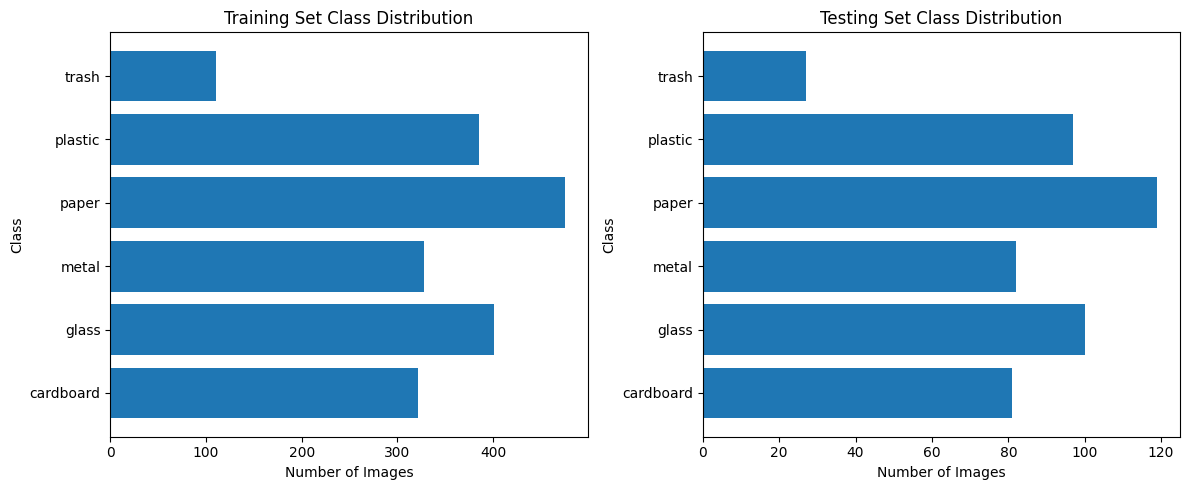

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Calculate class distributions
train_counter = Counter([dataset.targets[i] for i in train_idx])
test_counter = Counter([dataset.targets[i] for i in test_idx])

train_labels = list(train_counter.keys())
train_values = list(train_counter.values())

test_labels = list(test_counter.keys())
test_values = list(test_counter.values())

# Plot the distributions with horizontal bars
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax[0].barh(train_labels, train_values, tick_label=[classes[i] for i in train_labels])
ax[0].set_title("Training Set Class Distribution")
ax[0].set_ylabel("Class")
ax[0].set_xlabel("Number of Images")

# Testing set distribution
ax[1].barh(test_labels, test_values, tick_label=[classes[i] for i in test_labels])
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_ylabel("Class")
ax[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()


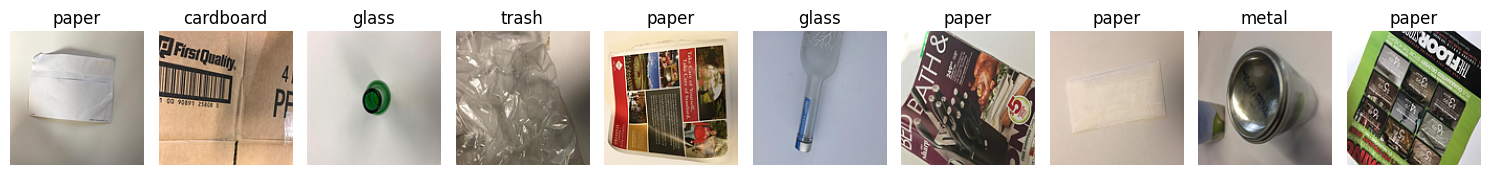

In [6]:
# Function to display images with labels
def imshow_with_labels(images, labels, classes):
    images = images / 2 + 0.5  # Unnormalize
    npimg = images.numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax.set_title(classes[labels[i].item()])  # Convert tensor to index and map to English
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first n images with labels
n = 10  # Display fewer images for readability
imshow_with_labels(images[:n], labels[:n], classes)


# Model

In [7]:
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 6

# Define ResNet-18
resnet18_model = resnet18(pretrained=True)
for param in resnet18_model.parameters():
    param.requires_grad = False  # Freeze all layers
# Unfreeze the last two residual blocks (layer3 and layer4)
for param in resnet18_model.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
# Modify the fully connected (FC) layer for 6 classes
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)
resnet18_model.fc.requires_grad = True  # Ensure the final layer is trainable
resnet18_model = resnet18_model.to(device)

# Define MobileNet_v2
mobilenet_v2_model = mobilenet_v2(pretrained=True)
for param in mobilenet_v2_model.features.parameters():
    param.requires_grad = False  # Freeze all layers in the features section
# Unfreeze the last two inverted residual blocks
for param in mobilenet_v2_model.features[-12:].parameters():  # Adjusted for two blocks
    param.requires_grad = True
# Modify the classifier for 6 classes
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, num_classes)
mobilenet_v2_model.classifier[1].requires_grad = True
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Define EfficientNet_B0
efficientnet_b0_model = efficientnet_b0(pretrained=True)
for param in efficientnet_b0_model.parameters():
    param.requires_grad = True
# Modify the classifier for 6 classes
efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, num_classes)
efficientnet_b0_model.classifier[1].requires_grad = True
efficientnet_b0_model = efficientnet_b0_model.to(device)

# Print a summary of one model (optional)
print(resnet18_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.0MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Before training

ResNet-18 Metrics:
Accuracy: 13.64%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.11      0.05      0.07        81
       glass       0.13      0.41      0.20       100
       metal       0.25      0.07      0.11        82
       paper       0.00      0.00      0.00       119
     plastic       0.20      0.15      0.18        97
       trash       0.07      0.11      0.09        27

    accuracy                           0.14       506
   macro avg       0.13      0.13      0.11       506
weighted avg       0.13      0.14      0.11       506



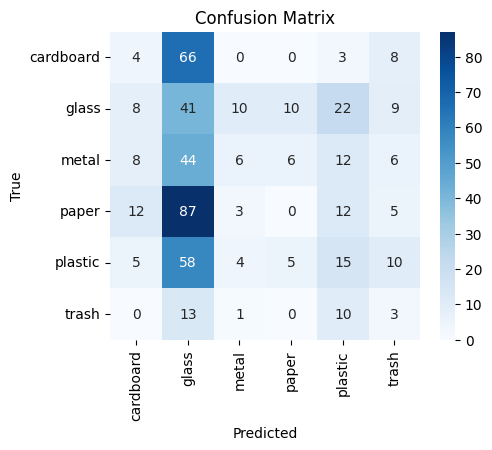


MobileNet_v2 Metrics:
Accuracy: 14.62%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.40      0.02      0.05        81
       glass       0.09      0.01      0.02       100
       metal       0.17      0.73      0.27        82
       paper       0.22      0.04      0.07       119
     plastic       0.40      0.02      0.04        97
       trash       0.04      0.15      0.06        27

    accuracy                           0.15       506
   macro avg       0.22      0.16      0.08       506
weighted avg       0.24      0.15      0.08       506



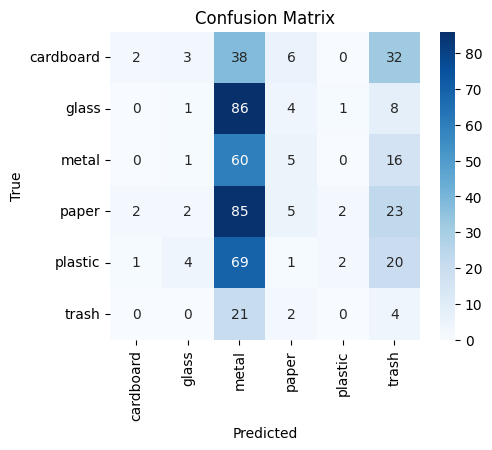


EfficientNet_B0 Metrics:
Accuracy: 11.86%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.14      0.31      0.19        81
       glass       0.07      0.04      0.05       100
       metal       0.22      0.18      0.20        82
       paper       0.13      0.03      0.04       119
     plastic       0.16      0.08      0.11        97
       trash       0.04      0.19      0.07        27

    accuracy                           0.12       506
   macro avg       0.13      0.14      0.11       506
weighted avg       0.13      0.12      0.11       506



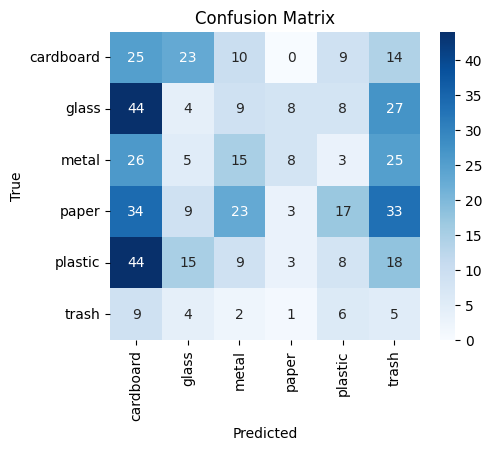

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to calculate detailed metrics
def evaluate_model(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, cm

# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_before, resnet18_report_before, resnet18_cm_before = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_before, mobilenet_v2_report_before, mobilenet_v2_cm_before = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_before, efficientnet_b0_report_before, efficientnet_b0_cm_before = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


# Training

In [9]:
import torch.optim as optim
from torch.utils.data import random_split
from collections import Counter
import random
from torchvision.transforms import functional as TF

# ================== Define the Training Function ==================
def train_model(model, train_loader, val_loader=None, criterion=None, optimizer=None, device=None, epochs=30, patience=10):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') if val_loader else None
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    return train_losses, val_losses if val_loader else train_losses

# ================== Split the Training Data ==================
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_idx, val_idx = random_split(range(len(train_set)), [train_size, val_size])

# Create subsets for training and validation
train_subset = torch.utils.data.Subset(train_set, train_idx)
val_subset = torch.utils.data.Subset(train_set, val_idx)

# ================== Class Balancing for Training Subset ==================
augmented_images = []
augmented_labels = []

# Count images per class
class_counts = Counter([train_set.dataset.targets[i] for i in train_idx])
max_class_count = max(class_counts.values())

# Augment underrepresented classes
for class_idx, count in class_counts.items():
    if count < max_class_count:
        diff = max_class_count - count
        print(f"Augmenting class {classes[class_idx]}: {count} -> {max_class_count}")

        # Get all images and their correct labels for this class
        class_images = [train_set.dataset[i] for i in train_idx if train_set.dataset.targets[i] == class_idx]

        # Apply augmentations
        for _ in range(diff):
            img, label = random.choice(class_images)  # Preserve correct label
            augmented_img = TF.rotate(img, angle=random.uniform(-15, 15))
            augmented_img = TF.hflip(augmented_img) if random.random() > 0.5 else augmented_img
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

# Combine original and augmented data for the training subset
train_dataset = [(train_set.dataset[i][0], train_set.dataset.targets[i]) for i in train_idx]
train_dataset.extend(zip(augmented_images, augmented_labels))

# ================== Create DataLoaders with tuned Batch Sizes ==================
train_loader_128 = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_128 = torch.utils.data.DataLoader(val_subset, batch_size=128, shuffle=False)

train_loader_32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_32 = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

# ================== Define Common Training Settings ==================
criterion = torch.nn.CrossEntropyLoss()

# ================== Train ResNet-18 ==================
print("Training ResNet-18...")
resnet18_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.000979, momentum=0.688444)
resnet18_train_losses, resnet18_val_losses = train_model(
    resnet18_model, train_loader_128, val_loader_128, criterion, resnet18_optimizer, device
)

# ================== Train MobileNet_v2 ==================
print("\nTraining MobileNet_v2...")
mobilenet_v2_optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=0.003236, momentum=0.643430)
mobilenet_v2_train_losses, mobilenet_v2_val_losses = train_model(
    mobilenet_v2_model, train_loader_32, val_loader_32, criterion, mobilenet_v2_optimizer, device
)

# ================== Train EfficientNet_B0 ==================
print("\nTraining EfficientNet_B0...")
efficientnet_b0_optimizer = optim.SGD(efficientnet_b0_model.parameters(), lr=0.000979, momentum=0.688444)
efficientnet_b0_train_losses, efficientnet_b0_val_losses = train_model(
    efficientnet_b0_model, train_loader_128, val_loader_128, criterion, efficientnet_b0_optimizer, device
)



Augmenting class glass: 406 -> 472
Augmenting class metal: 334 -> 472
Augmenting class cardboard: 313 -> 472
Augmenting class plastic: 91 -> 472
Training ResNet-18...
Epoch 1/30, Train Loss: 1.7043, Val Loss: 1.5971
Epoch 2/30, Train Loss: 1.2017, Val Loss: 1.3801
Epoch 3/30, Train Loss: 0.9413, Val Loss: 1.2460
Epoch 4/30, Train Loss: 0.7724, Val Loss: 1.1669
Epoch 5/30, Train Loss: 0.6646, Val Loss: 1.1002
Epoch 6/30, Train Loss: 0.5809, Val Loss: 1.0551
Epoch 7/30, Train Loss: 0.5057, Val Loss: 1.0144
Epoch 8/30, Train Loss: 0.4488, Val Loss: 0.9798
Epoch 9/30, Train Loss: 0.3984, Val Loss: 0.9546
Epoch 10/30, Train Loss: 0.3643, Val Loss: 0.9442
Epoch 11/30, Train Loss: 0.3327, Val Loss: 0.9234
Epoch 12/30, Train Loss: 0.2962, Val Loss: 0.9114
Epoch 13/30, Train Loss: 0.2767, Val Loss: 0.8946
Epoch 14/30, Train Loss: 0.2452, Val Loss: 0.8825
Epoch 15/30, Train Loss: 0.2301, Val Loss: 0.8776
Epoch 16/30, Train Loss: 0.2160, Val Loss: 0.8575
Epoch 17/30, Train Loss: 0.1978, Val Loss:

# After training

ResNet-18 Metrics:
Accuracy: 83.60%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.95      0.95      0.95        81
       glass       0.77      0.95      0.85       100
       metal       0.78      0.98      0.86        82
       paper       0.82      0.96      0.88       119
     plastic       0.95      0.59      0.73        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.84       506
   macro avg       0.71      0.74      0.71       506
weighted avg       0.81      0.84      0.81       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


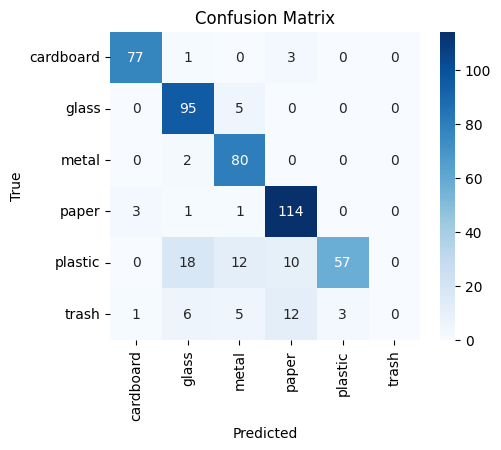


MobileNet_v2 Metrics:
Accuracy: 87.75%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.96      0.99      0.98        81
       glass       0.81      0.98      0.89       100
       metal       0.85      1.00      0.92        82
       paper       0.87      0.99      0.93       119
     plastic       0.93      0.68      0.79        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.88       506
   macro avg       0.74      0.77      0.75       506
weighted avg       0.84      0.88      0.85       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


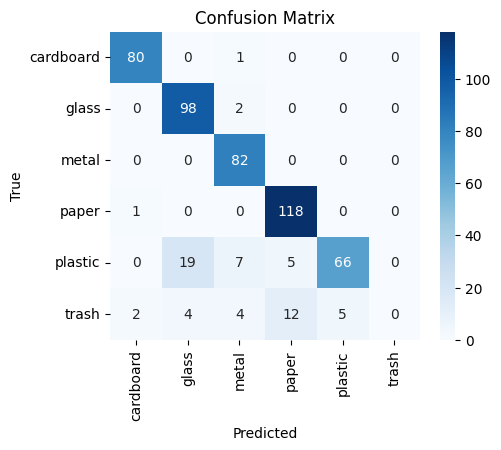


EfficientNet_B0 Metrics:
Accuracy: 78.46%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.94      0.93      0.93        81
       glass       0.75      0.83      0.79       100
       metal       0.75      0.87      0.80        82
       paper       0.75      0.93      0.83       119
     plastic       0.80      0.59      0.68        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.78       506
   macro avg       0.66      0.69      0.67       506
weighted avg       0.75      0.78      0.76       506



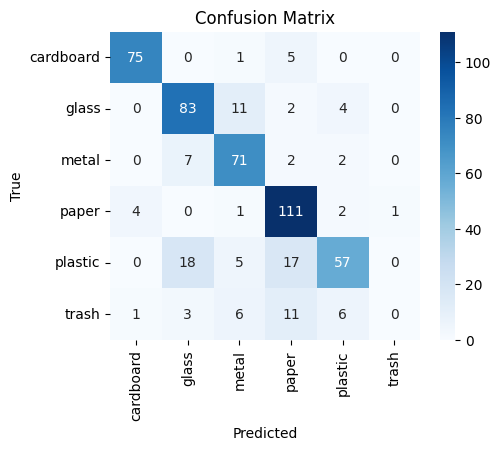

In [10]:
# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_after, resnet18_report_after, resnet18_cm_after = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_after, mobilenet_v2_report_after, mobilenet_v2_cm_after = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_after, efficientnet_b0_report_after, efficientnet_b0_cm_after = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


In [11]:
# Store results for comparison
results = {
    "ResNet-18": {
        "Before Training": {"Accuracy": resnet18_accuracy_before},
        "After Training": {"Accuracy": resnet18_accuracy_after},
    },
    "MobileNet_v2": {
        "Before Training": {"Accuracy": mobilenet_v2_accuracy_before},
        "After Training": {"Accuracy": mobilenet_v2_accuracy_after},
    },
    "EfficientNet_B0": {
        "Before Training": {"Accuracy": efficientnet_b0_accuracy_before},
        "After Training": {"Accuracy": efficientnet_b0_accuracy_after},
    },
}

# Print the summarized results
for model, accuracy in results.items():
    print(f"\n{model} Results:")
    print(f"  Before Training Accuracy: {accuracy['Before Training']['Accuracy']:.2f}%")
    print(f"  After Training Accuracy: {accuracy['After Training']['Accuracy']:.2f}%")



ResNet-18 Results:
  Before Training Accuracy: 13.64%
  After Training Accuracy: 83.60%

MobileNet_v2 Results:
  Before Training Accuracy: 14.62%
  After Training Accuracy: 87.75%

EfficientNet_B0 Results:
  Before Training Accuracy: 11.86%
  After Training Accuracy: 78.46%


ResNet-18 Misclassifications:


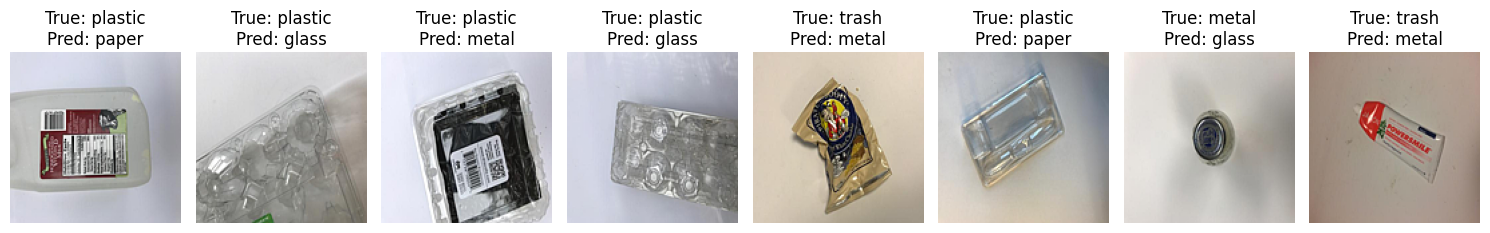

In [12]:
def visualize_misclassifications(model, data_loader, device, classes, num_images=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    # Handle case with fewer misclassifications
    num_to_plot = min(len(misclassified), num_images)

    # Plot misclassified images
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 5))
    if num_to_plot == 1:
        axes = [axes]  # Handle single subplot case
    for ax, (img, true_label, pred_label) in zip(axes, misclassified):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize for ResNet-18
print("ResNet-18 Misclassifications:")
visualize_misclassifications(resnet18_model, test_loader, device, classes, num_images=8)


In [13]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 102.1 MB/s eta 0:00:00


In [14]:
import torch

# Define function to export a PyTorch model to ONNX
def export_to_onnx(model, model_name, save_path, device):
    model = model.to(device)  # Ensure model is on the correct device
    model.eval()
    dummy_input = torch.randn(1, 3, 128, 128).to(device)  # Match input tensor to model's device
    torch.onnx.export(
        model,
        dummy_input,
        save_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"]
    )
    print(f"{model_name} exported to ONNX format at: {save_path}")

# Export each model using their respective variables
export_to_onnx(resnet18_model, "ResNet-18", "resnet18.onnx", device)
export_to_onnx(mobilenet_v2_model, "MobileNet_v2", "mobilenet_v2.onnx", device)
export_to_onnx(efficientnet_b0_model, "EfficientNet_B0", "efficientnet_b0.onnx", device)


ResNet-18 exported to ONNX format at: resnet18.onnx
MobileNet_v2 exported to ONNX format at: mobilenet_v2.onnx
EfficientNet_B0 exported to ONNX format at: efficientnet_b0.onnx


In [2]:
!pip install onnx-tf tensorflow tensorflow-addons

In [4]:
!pip uninstall tensorflow tensorflow-probability tensorflow-addons numpy -y

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [5]:
!pip install numpy==1.26.4 --force-reinstall
!pip install tensorflow==2.15.0 tensorflow-probability onnx-tf

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires tensorflow>=2.2.0, which is not installed.
dopamine-rl 4.0.9 requires tensorflow-probability>=0.13.0, which is not installed.
onnx-tf 1.10.0 requires tensorflow-addons, which is not installed.
nibabel 5.3.2 requires typing-extensions>=4.6; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
  Using cached tensorflow_probability-0.25.0-py2.py3-none-any.whl.metadata (13 kB)
  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:

In [3]:
!pip uninstall tensorflow-probability -y

Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0


In [6]:
!pip install tensorflow-probability==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.9 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import numpy as np

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.15.0
NumPy version: 1.26.4


In [7]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability loaded successfully!")

TensorFlow version: 2.15.0
TensorFlow Probability loaded successfully!


In [8]:
from onnx_tf.backend import prepare
import onnx

# Define ONNX to TensorFlow SavedModel conversion
onnx_saved_model_pairs = [
    ("resnet18.onnx", "resnet18.saved_model"),
    ("mobilenet_v2.onnx", "mobilenet_v2.saved_model"),
    ("efficientnet_b0.onnx", "efficientnet_b0.saved_model")
]

# Convert ONNX models to TensorFlow SavedModel
for onnx_path, saved_model_path in onnx_saved_model_pairs:
    try:
        # Load ONNX model
        onnx_model = onnx.load(onnx_path)

        # Convert ONNX model to TensorFlow representation
        tf_rep = prepare(onnx_model)

        # Export to TensorFlow SavedModel format
        tf_rep.export_graph(saved_model_path)
        print(f"Successfully converted {onnx_path} to {saved_model_path}")
    except Exception as e:
        print(f"Error converting {onnx_path} to {saved_model_path}: {e}")


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_62_x, add_19_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to resnet18.saved_model/fingerprint.pb


Successfully converted resnet18.onnx to resnet18.saved_model


INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_156_x, add_51_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to mobilenet_v2.saved_model/fingerprint.pb


Successfully converted mobilenet_v2.onnx to mobilenet_v2.saved_model


INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_243_x, add_80_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to efficientnet_b0.saved_model/fingerprint.pb


Successfully converted efficientnet_b0.onnx to efficientnet_b0.saved_model


In [9]:
import tensorflow as tf

# List of TensorFlow SavedModel and target TFLite filenames
saved_model_tflite_pairs = [
    ("resnet18.saved_model", "resnet18.tflite"),
    ("mobilenet_v2.saved_model", "mobilenet_v2.tflite"),
    ("efficientnet_b0.saved_model", "efficientnet_b0.tflite")
]

# Convert TensorFlow SavedModel to TFLite
for saved_model_path, tflite_path in saved_model_tflite_pairs:
    try:
        # Initialize TFLite Converter
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

        # Apply INT8 Quantization (optional but helps reduce size)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]  # Optional for further optimization

        # Convert to TFLite
        tflite_model = converter.convert()

        # Save the TFLite model
        with open(tflite_path, "wb") as f:
            f.write(tflite_model)
        print(f"Successfully converted {saved_model_path} to {tflite_path}")
    except Exception as e:
        print(f"Error converting {saved_model_path} to {tflite_path}: {e}")


Successfully converted resnet18.saved_model to resnet18.tflite
Successfully converted mobilenet_v2.saved_model to mobilenet_v2.tflite
Successfully converted efficientnet_b0.saved_model to efficientnet_b0.tflite


In [14]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="resnet18.tflite")
interpreter.allocate_tensors()

# Check input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Data Type:", input_details[0]['dtype'])
print("Output Data Type:", output_details[0]['dtype'])


Input Data Type: <class 'numpy.float32'>
Output Data Type: <class 'numpy.float32'>


In [11]:
import tensorflow as tf
import numpy as np

# Function to test a TFLite model
def test_tflite_model(tflite_path, input_shape):
    try:
        # Load the TFLite model
        interpreter = tf.lite.Interpreter(model_path=tflite_path)
        interpreter.allocate_tensors()

        # Get input and output tensor details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        print(f"Testing {tflite_path} ...")
        print("Input details:", input_details)
        print("Output details:", output_details)

        # Create a dummy input with correct NCHW shape (1, 3, 128, 128)
        dummy_input = np.random.rand(*input_shape).astype(np.float32)

        # Reshape input if required
        interpreter.set_tensor(input_details[0]['index'], dummy_input)

        # Run inference
        interpreter.invoke()

        # Get the output tensor
        output = interpreter.get_tensor(output_details[0]['index'])
        print(f"Output shape: {output.shape}")
        print(f"Output (first 5 values): {output.flatten()[:5]}")
        print("Inference successful!\n")
    except Exception as e:
        print(f"Error testing {tflite_path}: {e}")

# Test all three models with correct input shape (1, 3, 128, 128)
tflite_models = [
    "resnet18.tflite",
    "mobilenet_v2.tflite",
    "efficientnet_b0.tflite"
]
input_shape = (1, 3, 128, 128)  # Correct NCHW input shape

for tflite_path in tflite_models:
    test_tflite_model(tflite_path, input_shape)


Testing resnet18.tflite ...
Input details: [{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1,   3, 128, 128], dtype=int32), 'shape_signature': array([  1,   3, 128, 128], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'PartitionedCall:0', 'index': 178, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([1, 6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output shape: (1, 6)
Output (first 5 values): [ 2.1685011  -1.0365361   0.2774651   0.46272486 -0.42051306]
Inference successful!

Testing mobilenet_v2.tflite ...
Input details: [{'name': 'serving_default_input:0', 

In [12]:
import os

# List of models
tflite_models = ["resnet18.tflite", "mobilenet_v2.tflite", "efficientnet_b0.tflite"]

# Print the sizes
for model in tflite_models:
    size_mb = os.path.getsize(model) / (1024 * 1024)
    print(f"{model} size: {size_mb:.2f} MB")


resnet18.tflite size: 21.34 MB
mobilenet_v2.tflite size: 4.26 MB
efficientnet_b0.tflite size: 7.71 MB
